In [3]:
from google.colab import files
uploaded = files.upload()   # Upload both: historical_data.csv and fear_greed_index.csv

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

Saving historical_data.csv to historical_data.csv
Saving fear_greed_index.csv to fear_greed_index.csv


In [4]:
hist = pd.read_csv("historical_data.csv", low_memory=False)
fg   = pd.read_csv("fear_greed_index.csv", low_memory=False)

print("Historical data shape:", hist.shape)
print("Fear/Greed data shape:", fg.shape)
print("\nHistorical columns:", hist.columns.tolist())
print("\nFear/Greed columns:", fg.columns.tolist())

Historical data shape: (211224, 16)
Fear/Greed data shape: (2644, 4)

Historical columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Fear/Greed columns: ['timestamp', 'value', 'classification', 'date']


In [5]:
hist["time"] = pd.to_datetime(hist["Timestamp"], unit="ms", errors="coerce")
if hist["time"].isna().any():
    print("Warning: some timestamps could not parse.")

# Normalize to date for merge
hist["date"] = hist["time"].dt.date

# Parse date in sentiment dataset
fg["date"] = pd.to_datetime(fg["date"], errors="coerce").dt.date

# Display a few rows
print("\nSample historical times/dates:")
display(hist[["Timestamp","time","date"]].head(5))
print("\nSample sentiment dates:")
display(fg[["date"] + [c for c in fg.columns if "Class" in c or "class" in c]].head(5))


Sample historical times/dates:


,Timestamp,time,date
0,1.730000e+12,2024-10-27 03:33:20,2024-10-27
1,1.730000e+12,2024-10-27 03:33:20,2024-10-27
2,1.730000e+12,2024-10-27 03:33:20,2024-10-27
3,1.730000e+12,2024-10-27 03:33:20,2024-10-27
4,1.730000e+12,2024-10-27 03:33:20,2024-10-27



Sample sentiment dates:


,date,classification
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear


In [6]:
class_col = [c for c in fg.columns if c.lower().startswith("classification") or "class" in c.lower()][0]
fg["Classification_clean"] = fg[class_col].astype(str).str.strip()

# Map to numeric
mapping = {"fear": -1, "neutral": 0, "greed": 1}
fg["sentiment_num"] = fg["Classification_clean"].str.lower().map(mapping).fillna(0)

print("\nSentiment value counts:")
print(fg["sentiment_num"].value_counts())

# Merge sentiment into trades by date
hist = hist.merge(
    fg[["date","Classification_clean","sentiment_num"]].drop_duplicates(),
    on="date",
    how="left"
)
print("\nAfter merge merge, sample:")
display(hist[["date","Classification_clean","sentiment_num"]].head(5))


Sentiment value counts:
sentiment_num
 0.0    1230
-1.0     781
 1.0     633
Name: count, dtype: int64

After merge merge, sample:


,date,Classification_clean,sentiment_num
0,2024-10-27,Greed,1.0
1,2024-10-27,Greed,1.0
2,2024-10-27,Greed,1.0
3,2024-10-27,Greed,1.0
4,2024-10-27,Greed,1.0


In [7]:
# Feature engineering
if "Closed PnL" in hist.columns:
    hist["trade_return"] = pd.to_numeric(hist["Closed PnL"], errors="coerce")
    hist["is_win"] = (hist["trade_return"] > 0).astype(int)
else:
    raise KeyError("Closed PnL column not found in historical_data.csv")

# Side encoding: buy/long => +1, sell/short => -1
if "Side" in hist.columns:
    hist["side_clean"] = hist["Side"].astype(str).str.lower().str.strip()
    hist["side_encoded"] = hist["side_clean"].map({"buy":1,"long":1, "sell":-1,"short":-1}).fillna(0)
else:
    hist["side_encoded"] = 0

# Size & price & notional
if "Size Tokens" in hist.columns:
    hist["size"] = pd.to_numeric(hist["Size Tokens"], errors="coerce")
else:
    hist["size"] = np.nan

price_col = None
for c in hist.columns:
    if c.lower().startswith("execution price") or c.lower()=="execution_price" or c.lower()=="price":
        price_col = c
        break
if price_col:
    hist["execution_price"] = pd.to_numeric(hist[price_col], errors="coerce")
else:
    hist["execution_price"] = np.nan

hist["notional"] = hist["execution_price"] * hist["size"]

# Leverage numeric
lev_col = None
for c in hist.columns:
    if "lever" in c.lower():
        lev_col = c
        break
if lev_col:
    hist["leverage"] = pd.to_numeric(hist[lev_col], errors="coerce")
else:
    hist["leverage"] = np.nan

print("\nSample of engineered features:")
display(hist[["trade_return","is_win","side_encoded","size","execution_price","notional","leverage"]].head(5))


Sample of engineered features:


,trade_return,is_win,side_encoded,size,execution_price,notional,leverage
0,0.0,0,1,986.87,7.9769,7872.163303,NaN
1,0.0,0,1,16.00,7.9800,127.680000,NaN
2,0.0,0,1,144.09,7.9855,1150.630695,NaN
3,0.0,0,1,142.98,7.9874,1142.038452,NaN
4,0.0,0,1,8.73,7.9894,69.747462,NaN


In [8]:
if "account" not in hist.columns:
    acc_alt = [c for c in hist.columns if "account" in c.lower()]
    if acc_alt:
        hist = hist.rename(columns={acc_alt[0]:"account"})
    else:
        hist["account"] = "unknown"

agg = hist.groupby("account").agg(
    total_trades   = ("trade_return","count"),
    win_rate       = ("is_win","mean"),
    avg_return     = ("trade_return","mean"),
    median_return  = ("trade_return","median"),
    std_return     = ("trade_return","std"),
    avg_leverage   = ("leverage","mean")
).reset_index()

agg["valid"] = agg["total_trades"] >= 10
print("\nAccount-level aggregated summary (top few):")
display(agg.sort_values("total_trades", ascending=False).head(8))


Account-level aggregated summary (top few):


,account,total_trades,win_rate,avg_return,median_return,std_return,avg_leverage,valid
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,40184,0.428230,20.806305,0.000000,264.123880,NaN,True
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,21192,0.467582,44.364091,0.000000,567.762763,NaN,True
23,0xa0feb3725a9335f49874d7cd8eaad6be45b27416,15605,0.345787,6.812104,0.000000,68.234904,NaN,True
21,0x8477e447846c758f5a675856001ea72298fd9cb5,14998,0.261968,2.928191,0.000000,68.613041,NaN,True
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,14733,0.337134,145.481748,0.000000,1374.026402,NaN,True
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,0.438585,9.951530,0.000000,113.269353,NaN,True
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,12236,0.401193,68.684419,0.000000,639.402444,NaN,True
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,9893,0.810876,38.319560,7.722845,172.520773,NaN,True


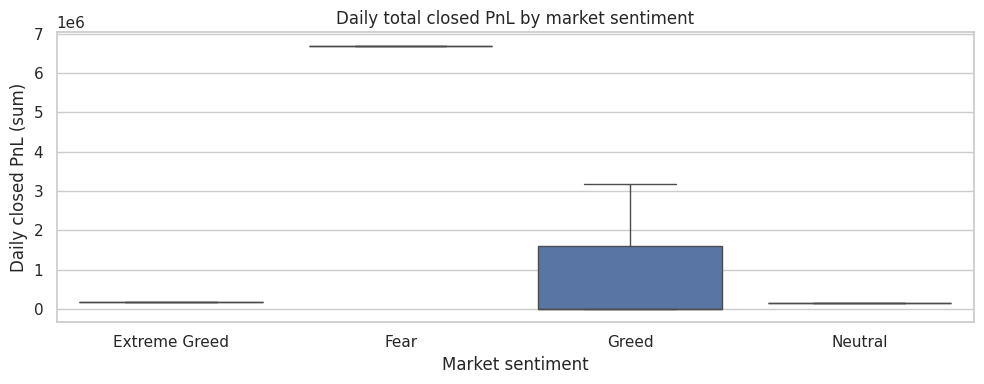


Win rate by sentiment:


,Classification_clean,win_rate,count
0,Extreme Greed,0.490089,6962
1,Fear,0.415146,133871
2,Greed,0.446471,36289
3,Neutral,0.317182,7141


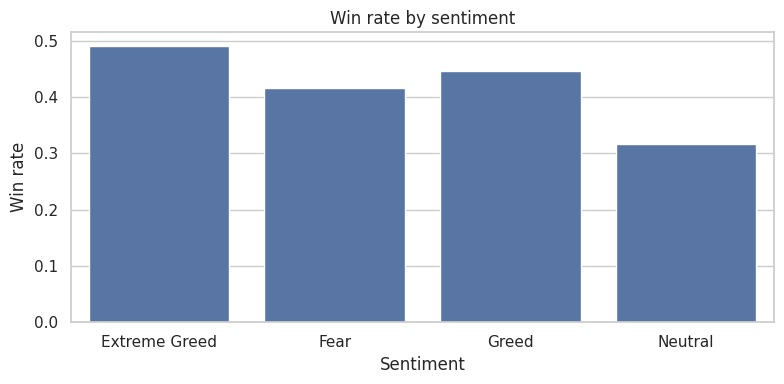

No leverage data available for leverage-bucket analysis.


In [10]:
# Exploratory Data Analysis (EDA) & plots
# Daily total PnL by sentiment (boxplot)
daily = hist.groupby("date").agg(daily_pnl=("trade_return","sum")).reset_index()
daily = daily.merge(
    fg[["date","Classification_clean"]].drop_duplicates(),
    on="date",
    how="left"
)
plt.figure(figsize=(10,4))
sns.boxplot(x="Classification_clean", y="daily_pnl", data=daily,
            order=sorted(daily["Classification_clean"].dropna().unique()))
plt.title("Daily total closed PnL by market sentiment")
plt.xlabel("Market sentiment")
plt.ylabel("Daily closed PnL (sum)")
plt.tight_layout()
plt.show()

# Win rate by sentiment
win_by_sent = hist.groupby("Classification_clean").agg(
    win_rate=("is_win","mean"),
    count=("is_win","count")
).reset_index()
print("\nWin rate by sentiment:")
display(win_by_sent)

plt.figure(figsize=(8,4))
sns.barplot(x="Classification_clean", y="win_rate", data=win_by_sent,
            order=win_by_sent["Classification_clean"])
plt.title("Win rate by sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Win rate")
plt.tight_layout()
plt.show()

# Avg return by leverage bucket & sentiment
if hist["leverage"].notna().sum()>0:
    hist["lev_bucket"] = pd.qcut(hist["leverage"].fillna(hist["leverage"].median()), q=3, labels=["low","mid","high"])
    lev_sent = hist.groupby(["lev_bucket","Classification_clean"]).agg(
        avg_return=("trade_return","mean"),
        count=("trade_return","count")
    ).reset_index()
    print("\nAverage return by leverage bucket & sentiment:")
    display(lev_sent.head(12))
    plt.figure(figsize=(8,4))
    sns.barplot(x="lev_bucket", y="avg_return", hue="Classification_clean", data=lev_sent)
    plt.title("Avg trade return by leverage bucket & sentiment")
    plt.xlabel("Leverage bucket")
    plt.ylabel("Avg trade return")
    plt.tight_layout()
    plt.show()
else:
    print("No leverage data available for leverage-bucket analysis.")

In [11]:
# Statistical Tests: Fear vs Greed trade returns
from scipy.stats import ttest_ind, mannwhitneyu

g_greed = hist[hist["Classification_clean"].str.lower().str.contains("greed",na=False)]["trade_return"].dropna()
g_fear  = hist[hist["Classification_clean"].str.lower().str.contains("fear",na=False)]["trade_return"].dropna()

print(f"\nGreed sample size: {len(g_greed)}, Fear sample size: {len(g_fear)}")
if len(g_greed)>=10 and len(g_fear)>=10:
    t_stat, p_val  = ttest_ind(g_greed, g_fear, equal_var=False, nan_policy="omit")
    u_stat, p_valu = mannwhitneyu(g_greed, g_fear, alternative="two-sided")
    # Cohen’s d
    def cohens_d(a,b):
        na, nb = len(a), len(b)
        sa, sb = a.std(ddof=1), b.std(ddof=1)
        pooled = np.sqrt(((na-1)*sa*sa + (nb-1)*sb*sb)/(na+nb-2))
        return (a.mean()-b.mean())/pooled if pooled>0 else np.nan

    d = cohens_d(g_greed, g_fear)
    print("t-test p-value:", p_val)
    print("Mann-Whitney p-value:", p_valu)
    print("Cohen’s d (Greed vs Fear):", round(d,4))
else:
    print("Not enough samples in one or both groups for robust test.")



Greed sample size: 43251, Fear sample size: 133871
t-test p-value: 9.421142077044365e-07
Mann-Whitney p-value: 3.5293405510364374e-34
Cohen’s d (Greed vs Fear): 0.0293


In [12]:
# Insights summary printout
print("\n=== Quick summary of key aggregates ===")
print("Average win rate by sentiment:")
print(win_by_sent.to_string(index=False))

print("\nTop account-level performers (valid accounts only):")
display(agg[agg["valid"]].sort_values("avg_return", ascending=False).head(5))


=== Quick summary of key aggregates ===
Average win rate by sentiment:
Classification_clean  win_rate  count
       Extreme Greed  0.490089   6962
                Fear  0.415146 133871
               Greed  0.446471  36289
             Neutral  0.317182   7141

Top account-level performers (valid accounts only):


,account,total_trades,win_rate,avg_return,median_return,std_return,avg_leverage,valid
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,383,0.234987,520.902331,0.0,2228.336140,NaN,True
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,0.359612,419.127768,0.0,4692.452329,NaN,True
9,0x430f09841d65beb3f27765503d0f850b8bce7713,1237,0.484236,336.735548,0.0,1649.497580,NaN,True
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,1430,0.306294,281.826227,0.0,1591.523958,NaN,True
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,1590,0.345912,270.034947,0.0,2525.240437,NaN,True
